In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Conv1D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [4]:
df=pd.read_csv("./emergency_call_binary_tokens.csv", encoding="utf-8-sig")
df.head()

Unnamed: 0  id                    document label  \
0           0   1    골목길에서 싸움이 났어요 다친 사람이 있어요    긴급   
1           1   2      교통사고가 발생했는데 상대방이 도주했어요    긴급   
2           2   3      집 근처에서 폭죽 소리가 나고 시끄러워요    경미   
3           3   4  술집에서 손님끼리 다투고 있어요 경찰이 필요해요    긴급   
4           4   5         차에 누가 돌을 던졌어요 잡아주세요    경미   

                                    tokens  
0         ['골목길', '싸움', '나다', '다치다', '사람']  
1  ['교통사고', '발생', '하다', '상대방', '도주', '하다']  
2    ['집', '근처', '폭죽', '소리', '나다', '시끄럽다']  
3  ['술집', '손님', '끼리', '다투다', '경찰', '필요하다']  
4            ['차', '누가', '돌', '던지다', '잡다']

In [3]:
padding_len = 32
embedding_dim = 1024

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['document'].apply(lambda x: ' '.join(x)))

sequences = tokenizer.texts_to_sequences(df['document'].apply(lambda x: ' '.join(x)))

X = pad_sequences(sequences, maxlen=padding_len, padding='post')

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (300, 32), y shape: (300,)


In [5]:
vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size: {vocab_size}")
print(f"max index in sequences: {np.max(X)}")

vocab_size: 361
max index in sequences: 360


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hidden_units =128

d1= 128
d2= 64

kernel_size = 3  # CNN 필터 크기
filters = 128    # CNN 필터 수

In [8]:
m_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    GlobalAveragePooling1D(),
    Dense(d1, activation='relu'),
    Dense(1, activation='sigmoid')
])

m_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    SimpleRNN(hidden_units, return_sequences=False),  # RNN 유닛 수는 필요시 조정 가능
    Dense(d1, activation='relu'),
    Dense(1, activation='sigmoid')
])

m_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),

    GRU(hidden_units, return_sequences=False),  # RNN 유닛 수는 필요시 조정 가능
    Dense(d1, activation='relu'),
    Dense(1, activation='sigmoid')
])

m_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    LSTM(hidden_units, return_sequences=False),  # RNN 유닛 수는 필요시 조정 가능
    Dense(d1, activation='relu'),
    Dense(1, activation='sigmoid')
])

m_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dense(d1, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [9]:
model_dict = {
    'mlp': m_mlp,
    'rnn': m_rnn,
    'lstm': m_lstm,
    'gru': m_gru,
    'cnn': m_cnn
}

## 여러 모델 한번에 실행하기

In [10]:
results = []
histories =[]
model_name=[]

for name, model in model_dict.items():
    print(f'\nTraing {name} model ...')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2)
    histories.append(history)
    results.append(model.evaluate(X_test, y_test))
    model_name.append(name)
    print(name, '\n테스트 정확도:', results[-1][1])


Traing mlp model ...
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - acc: 0.4564 - loss: 0.6862 - val_acc: 0.4583 - val_loss: 0.7251
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.6061 - loss: 0.6655 - val_acc: 0.4583 - val_loss: 0.7364
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.6146 - loss: 0.6566 - val_acc: 0.4583 - val_loss: 0.7383
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.6543 - loss: 0.6246 - val_acc: 0.4583 - val_loss: 0.7393
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.6387 - loss: 0.6224 - val_acc: 0.4792 - val_loss: 0.7125
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.6230 - loss: 0.6185 - val_acc: 0.5000 - val_loss: 0.6896
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.6621 - loss: 0.5837 - val_acc: 0.5000 - val_loss: 0.6865
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.6953 - loss: 0.5484 - val_acc: 0.5833 - val_loss: 0.6772
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0

In [11]:
def plot_model_comparision(histories, results, model_names):
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label={name})
        #plt.plot(history.history['val_loss'], label=f'val_{name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend(frameon=False)

    plt.subplot(1,2,2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['acc'], label=name)
        #plt.plot(history.history['val_acc'], label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy')
    plt.legend(frameon=False)
    plt.show()

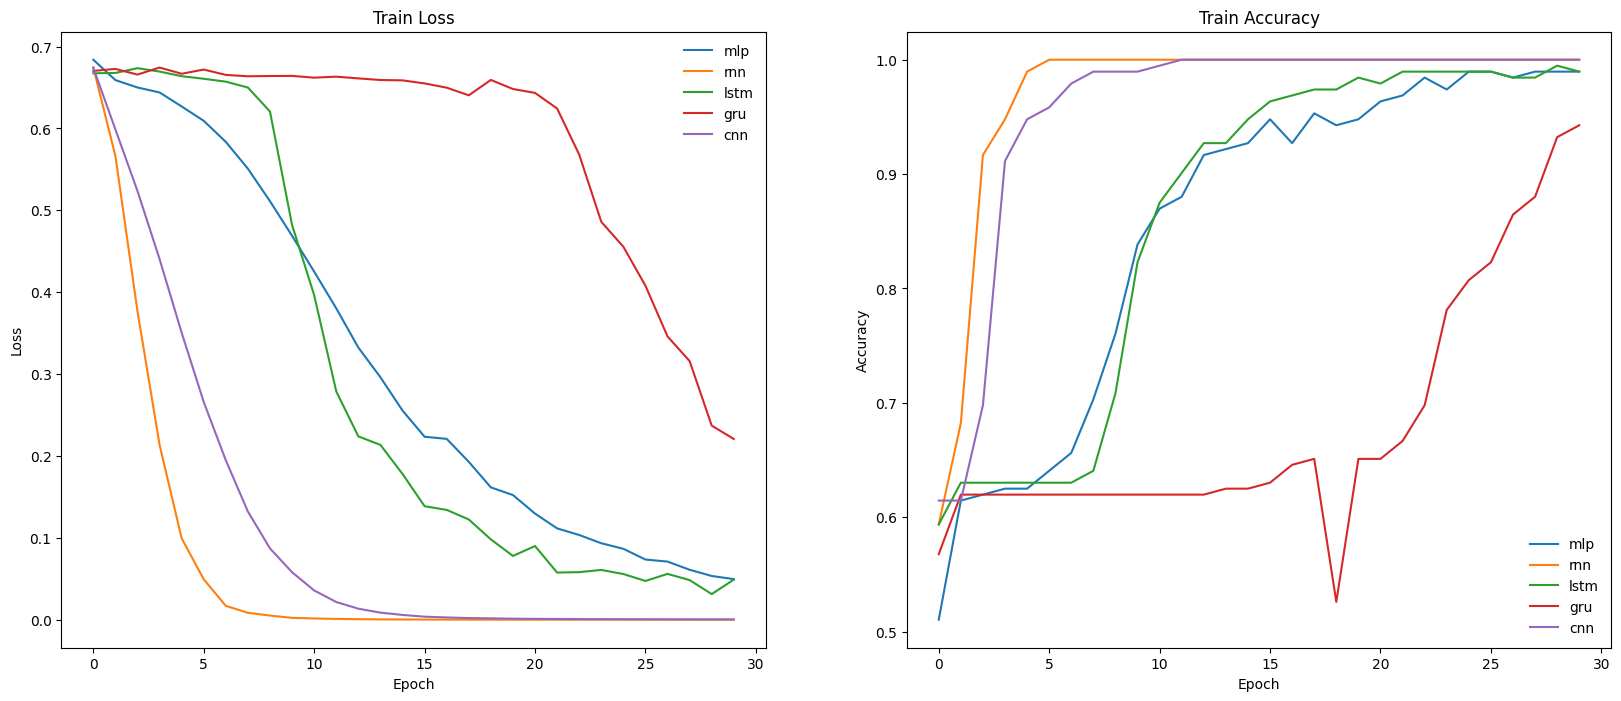

In [12]:
plot_model_comparision(histories, results, model_dict)

In [13]:
df1=pd.DataFrame(model_name)
df1.columns=['model_name']

df2=pd.DataFrame(results)
df2.columns=['loss','accuracy']

df=pd.concat([df1,df2],axis=1)
print(df)

  model_name      loss  accuracy
0        mlp  1.011537  0.700000
1        rnn  2.250408  0.633333
2       lstm  1.608297  0.650000
3        gru  1.016353  0.616667
4        cnn  1.125479  0.750000


In [17]:
df.plot.bar(x='model_name', y='accuracy', ylabel='Accuracy')
plt.ylim(0, 1)  # y축 범위 설정
plt.xticks(rotation=15)  # x축 라벨 각도 조정
plt.legend(frameon=False)
plt.show()

In [16]:
df.plot.bar(x='model_name', y='loss', ylabel='Loss')
#plt.ylim(0, 1.9)  # y축 범위 설정
plt.legend(frameon=False)
plt.xticks(rotation=15)  # x축 라벨 각도 조정
plt.show()